# Here we will consider two example applications for PCA

## Blink artifact removal from EEG data

In this example we are using PCA to do blind source separation. The EEG measurement has 32 channels spread across the scalp.

![EEG Cap Layout](caplayout.jpg)

Each time the subject blinks, there is a stereotypical artifact, that is strongest in the electrodes in front of the head (i.e., closer to the eyes), and becomes weaker towards the electrodes at the back of the head.

In [1]:
import numpy as np
from scipy import io
import pylab as pl

dat = io.loadmat('SSPexample/EEG_SSPdata.mat', squeeze_me=True)

In [2]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'blink_samples', 'channel_names', 'dat', 'fs', 'pos'])

In [3]:
x = dat['dat'] * 1e6  # Convert to microvolts, raw data is in volts
fs = dat['fs']

### Let's plot the first 10 seconds of the data
The full data is ~5 mins long

Text(0.5, 0, 'Time (s)')

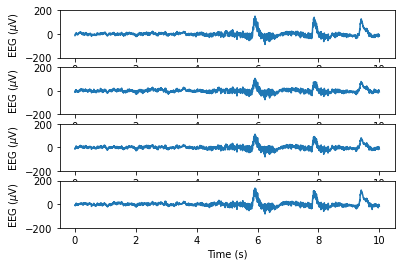

In [4]:
t = np.arange(0, 10, 1/fs)

chans_to_plot = [0, 28, 1, 29]  # Choose some channels to plot
nchans_to_plot = len(chans_to_plot)
for k, chan in enumerate(chans_to_plot):
    pl.subplot(nchans_to_plot, 1, k+1)
    pl.plot(t, x[chan, :(10*fs)].T)
    pl.ylim(-200, 200)
    pl.ylabel('EEG ($\mu$V)')
pl.xlabel('Time (s)')


### Extract samples containing blinks to perform PCA

A peak picking algorithm has already been used to find the peaks of the blinks, in ```blink_samples```.
By choosing samples around each blink, PCA will more effectively find that source.

In the code below, the variable ```b``` is used to extract samples from 200 ms before to 200 ms after each blink and only keep those samples for computing the data covariance needed for PCA. The full data, i.e., ```x``` can also be used, but then we won't know which eigenvector will correspond to the blink artifact source. By selecting mainly artifactual samples, we know that the eigenvector with the highest eigenvalue corresponds to the blink source.

In [5]:
blink_samples = dat['blink_samples']

In [6]:
tmin = -0.2
tmax = 0.2
nchans = x.shape[0]
b = np.zeros((nchans, 0))
for k, blink in enumerate(blink_samples):
    b = np.concatenate((b, x[:, (blink + int(tmin*fs)):(blink + int(tmax*fs))]), axis=1)

In [7]:
C = np.cov(b)

In [8]:
C.shape

(32, 32)

In [9]:
eigvals, Q = np.linalg.eigh(C)

Text(0, 0.5, 'Eigenvector weights for Prin. Comp.')

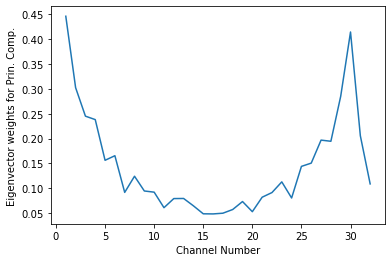

In [10]:
q_blink = Q[:, -1]
pl.plot(np.arange(nchans) + 1, q_blink)
pl.xlabel('Channel Number')
pl.ylabel('Eigenvector weights for Prin. Comp.')

### Now let's plot the extracted sources (i.e., the principal component)

The function ```numpy.linalg.eigh``` sorts the eigenvectors from low to high eigenvalues, so the last component (index 31) will be theh blink source. None of the other principal components should contain blinks if the assumptions required for PCA are satisfied. You can check this by plotting any of the first 31 components (indices 0 through 30).

(-400.0, 400.0)

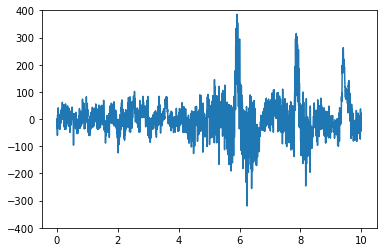

In [11]:
pc = np.dot(Q[:, 31], x)
pl.plot(t, pc[:(10*fs)])
pl.ylim(-400, 400)

### Now let's project the data orthogonal to the blink PCA vector

This is essentially subtracting the blink component from the original measurement. This is equivalent to unmixing your 32 channels to get 32 principal components (PC). Making the PC corresponding to the blink component a zero signal, and then re-mixing them back to the original channel space.

In [12]:
P = np.eye(nchans) - np.outer(q_blink, q_blink)

In [13]:
y = np.dot(P, x)

Text(0.5, 0, 'Time (s)')

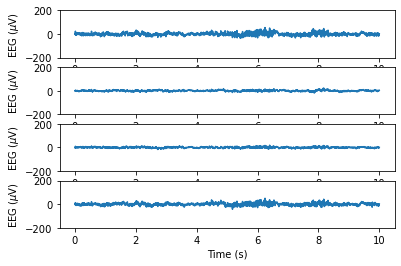

In [14]:
# Artifact suppressed/Cleaned
for k, chan in enumerate(chans_to_plot):
    pl.subplot(nchans_to_plot, 1, k+1)
    pl.plot(t, y[chan, :(10*fs)].T)
    pl.ylim(-200, 200)
    pl.ylabel('EEG ($\mu$V)')
pl.xlabel('Time (s)')

---

## PAN-CANCER ATLAS RNAseq data -- 801 samples across 20,531 genes
Five cancer types are represented. The goal of the PAN-CANCEL project was to 
characterize similarities and differences in gene-expression across different
cancer types so that drugs developed for one type may be adapted to other
types as appropriate.

### Label abbreviations:

- COAD - Colon Adenocarcinoma
- BRCA - Breast Invasive Carcinoma
- KIRC - Kidney Renal Clear Cell Carcinoma
- LUAD - Lung Adenocarcinoma
- PRAD - Prostate Adenocarcinoma

### Rather then doing PCA by hand, we will use the PCA functions in scikit-learn

Scikit-learn is one of the most commonly used machine-learning libraries, which thankfully is built using Python. In later parts of this course, we will use scikit-learn to explore a range of machine-learning techniques/"models".

When the dimensionality is very high to begin with, computing covariance matrices and then calculating eigen vectors is computations inefficient. The PCA function in scikit-learn can take more efficient numerical shortcuts (e.g., using SVD) to arrive at the same answer but skip some time-consuming intermediate steps.

Moreover, we will use ```pandas``` for working with table of data, reading CSV files, etc.


In [15]:
import pandas as pd
# Read Data
dat = pd.read_csv('CANCER_RNAseq_DATA/data.csv')
X = np.float64(dat.to_numpy()[:, 1:])

# Read Labels
labs = pd.read_csv('CANCER_RNAseq_DATA/labels.csv')
y = labs['Class'].to_numpy()

Scikit-learn (```sklearn```) implements many data decomposition techniques using roughly the same series of modular steps:
- Define a "model"
- Fit the model to some data
- Apply fitted model to (the same or different) data

In this scheme, we specify the "model" that we want as one where we will do PCA, but keep only the top three components (i.e., the three with the highest variance). Then the PCA eigenvectors are actually estimated in the ```fit``` step. In the final step, the three PCs are extracted by applying the eigenvectors to the original measurements in the ```transform``` step. The names of these functions will make more sense as we start using other machine-learning models in the future.

In [16]:
from sklearn.decomposition import PCA
# Do PCA to get 3 dimensions
pc = PCA(n_components=3)
pc.fit(X)
X_pc = pc.transform(X)


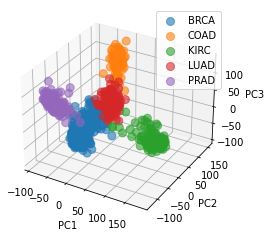

In [17]:
# Plot clusters with different labels in different colors
fig = pl.figure()
ax = fig.add_subplot(projection='3d')
for label in np.unique(y):
    inds = np.where(y == label)
    ax.scatter(X_pc[inds, 0], X_pc[inds, 1], X_pc[inds, 2],
                s=64, alpha=0.6)
pl.xlabel('PC1')
pl.ylabel('PC2')
ax.set_zlabel('PC3')
pl.legend(np.unique(y))